In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats
from sklearn.manifold import TSNE

In [82]:
df = pd.read_csv("hw2_dataset.csv")
print(df.info())
df.head(5)
has_missing = df.isnull().any().any()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Columns: 1025 entries, ID to D_1023
dtypes: int64(1024), object(1)
memory usage: 7.6+ MB
None


### Our data include only binary numbers, and is a 969x1025 dataframe. Also, there are no missing values

## K-mean Clustering

### Elbow Method:

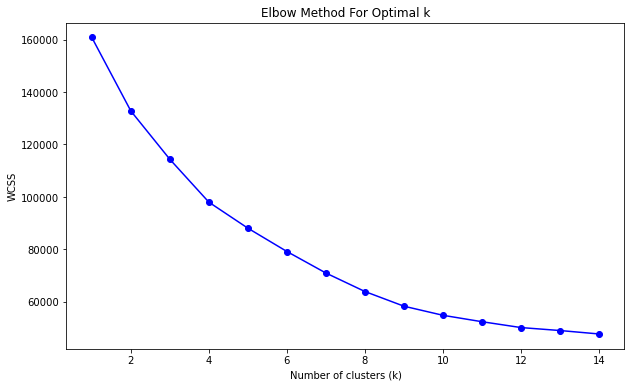

In [83]:
df1 = df.drop(df.columns[0], axis=1)

wcss = []  # Within-Cluster-Sum-of-Squares
K = range(1, 15)  # Adjust range as needed
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df1)
    wcss.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()


In [84]:
differences = [wcss[i] - wcss[i+1] for i in range(len(wcss)-1)]
differences


[28015.10026567246,
 18426.052356247354,
 16337.72978073117,
 9916.356772516316,
 8884.03386883509,
 8211.610926515845,
 7045.201648845323,
 5597.04318949578,
 3463.374768482914,
 2447.6554342122545,
 2228.9445839534455,
 1128.9686667940914,
 1311.1409706552367]

In [85]:
slope = [-(differences[i] - differences[i+1]) for i in range(len(differences)-1)]
slope

[-9589.047909425106,
 -2088.322575516184,
 -6421.373008214854,
 -1032.3229036812263,
 -672.4229423192446,
 -1166.409277670522,
 -1448.1584593495427,
 -2133.668421012866,
 -1015.7193342706596,
 -218.71085025880893,
 -1099.9759171593541,
 182.17230386114534]

#### By solely relying on the elbow method's plot, it's challenging to discern the exact point where the graph begins to stabilize, making it difficult to conclusively determine the optimal number of clusters. 
#### To address this uncertainty, I calculated the slope between consecutive points to identify where the slope starts to stabilize. The results indicate that, after the cluster number reaches 9, the slope remains relatively constant at around -1000, 
#### Based on this observation, I've selected 9 as the optimal number of clusters.

### Peform K-mean & visualize using t-SNE:

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


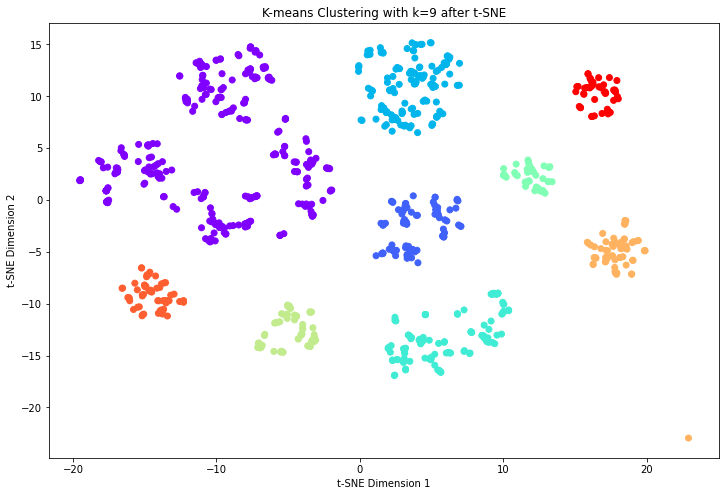

In [86]:

#Perfrom k-mean with 9 cluster and set a seed 527 as the initial centroids
kmeans = KMeans(n_clusters=9, random_state=527)
#By default, it uses Euclidean distance
clusters = kmeans.fit_predict(df1)
#Visualize using tSNE
reduced = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=527).fit_transform(df1)

#Plotting the clusters
plt.figure(figsize=(12, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='rainbow')
plt.title('K-means Clustering with k=9 after t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## Another Cluster Method : DBSCAN

### k-distance method to find eps:

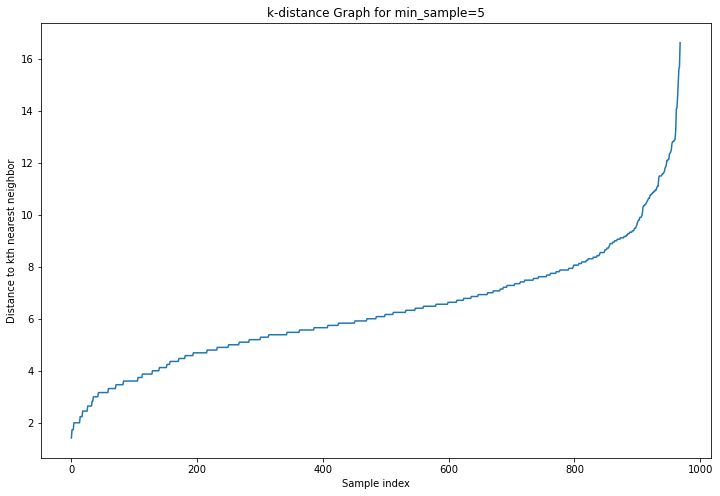

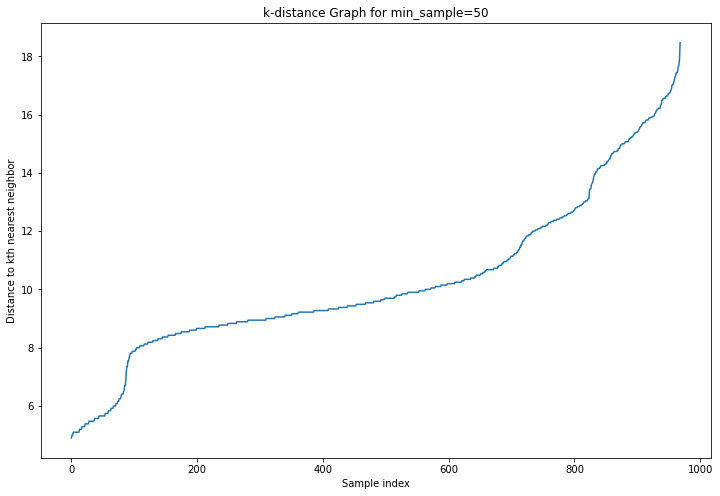

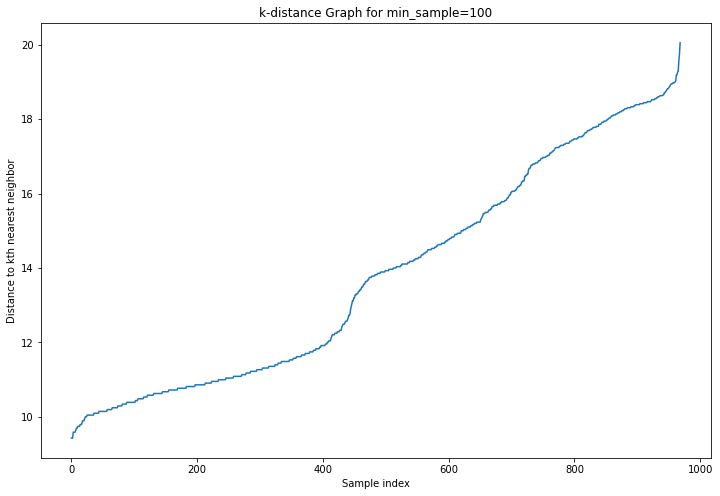

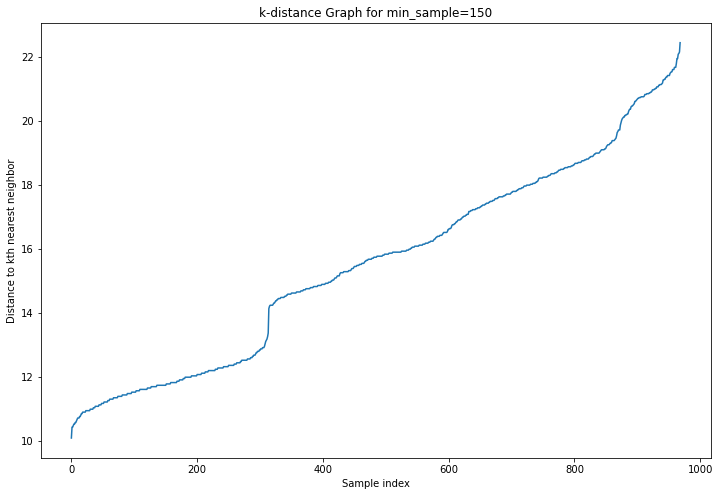

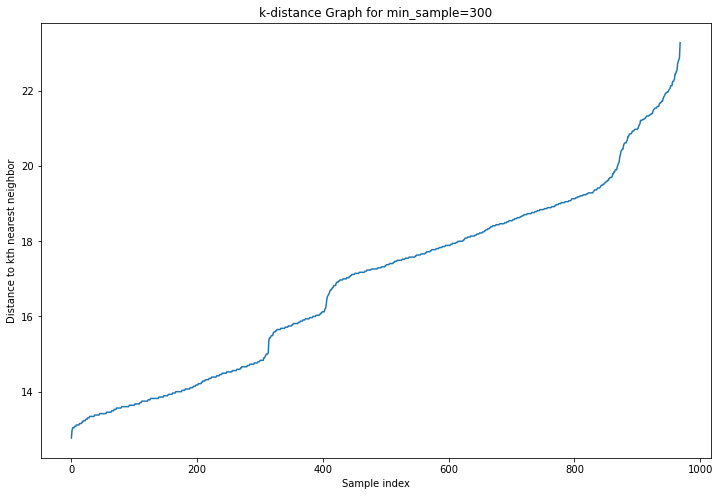

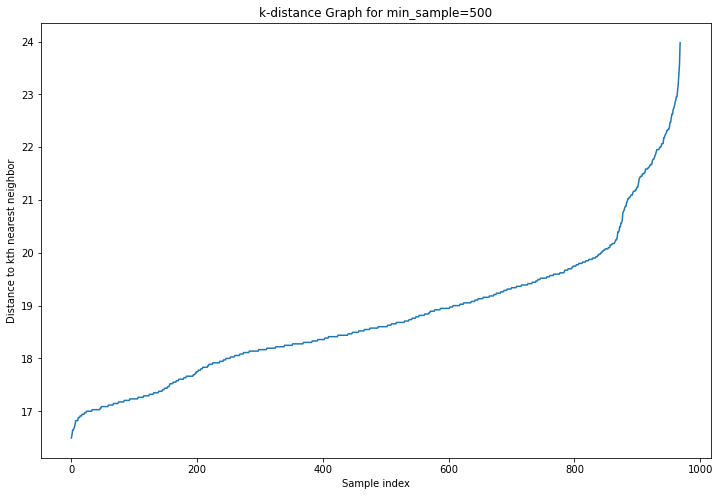

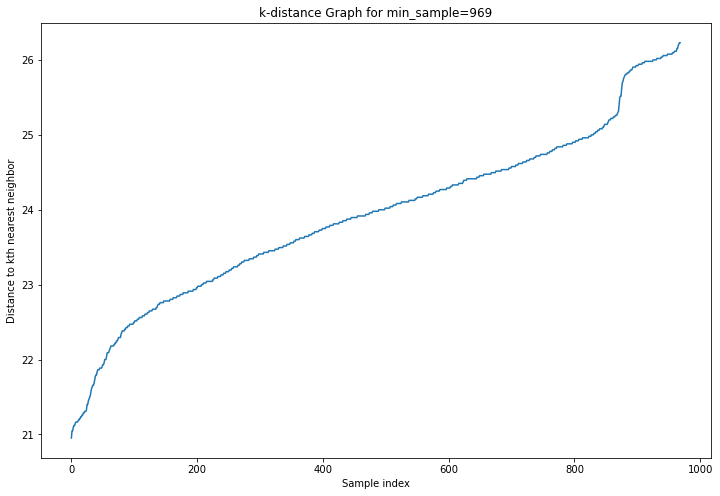

In [92]:
from sklearn.neighbors import NearestNeighbors
# minS is the neighbors for k-distance graph
minS = [5,50,100,150,300,500,969]
for i in range(len(minS)):
    # Compute the nearest neighbors
    nearest_neighbors = NearestNeighbors(n_neighbors=minS[i])
    nearest_neighbors_fit = nearest_neighbors.fit(df1)
    distances, indices = nearest_neighbors_fit.kneighbors(df1)

    # Sort the distances and plot
    sorted_distances = np.sort(distances[:, -1], axis=0)
    plt.figure(figsize=(12, 8))
    plt.plot(sorted_distances)
    plt.xlabel('Sample index')
    plt.ylabel('Distance to kth nearest neighbor')
    plt.title('k-distance Graph for min_sample=%d'% minS[i])
    plt.show()

#### The parameter 'eps' in DBSCAN specifies the radius of the neighborhoods around data points. By utilizing the k-distance graph, I can determine the corresponding 'eps' value for the DBSCAN cluster. This value aligns with the y-coordinate where a pronounced change is evident in the graph, signifying a shift from denser regions of the cluster to sparser ones.
#### In plotting the k-distance graphs, I experimented with several 'min_samples' values ranging from 5 to the number of rows of my df to observe the corresponding eps values. The min_samples specifies the minimum number of data points required to form a dense region. In the subsequent steps, I will visualize the DBSCAN method using these pairs to determine the most optimal values.
#### Observation: As the min_sample increases, 'eps' tends to increase too.

In [ ]:
eps_values = np.linspace(0.1, 2, 26)  # example range, adjust as needed
min_samples_values = range(1, 969)     # example range, adjust as needed

from sklearn.metrics import silhouette_score

best_score = -1  # initialize with a low value
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df1)
        
        # Make sure we have more than 1 cluster (to compute silhouette score)
        if len(np.unique(clusters)) > 1:
            score = silhouette_score(df1, clusters)
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
print(best_eps)
print(best_min_samples)

### Peform DBSCAN & visualize using t-SNE:

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


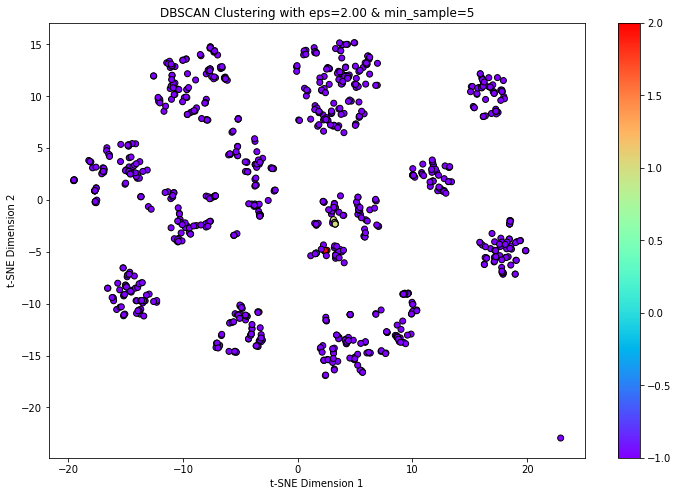

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


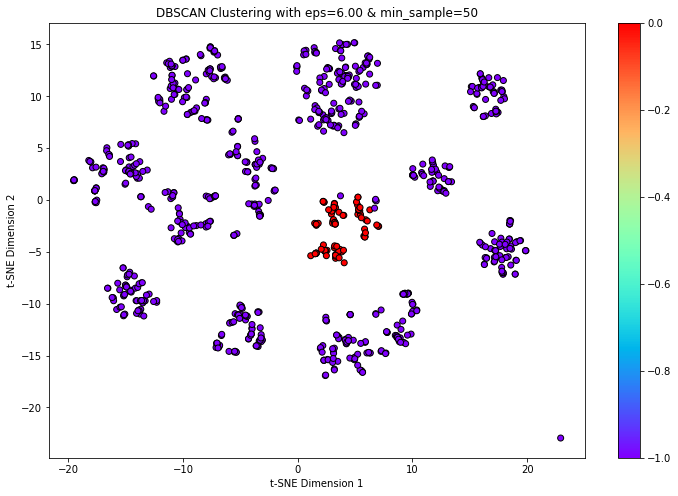

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


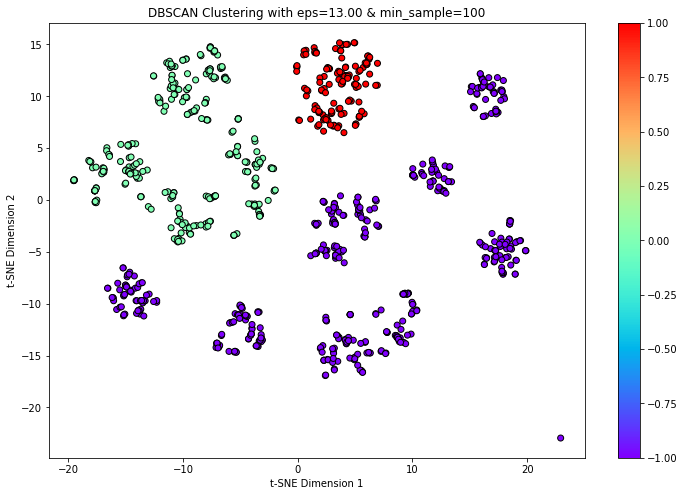

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


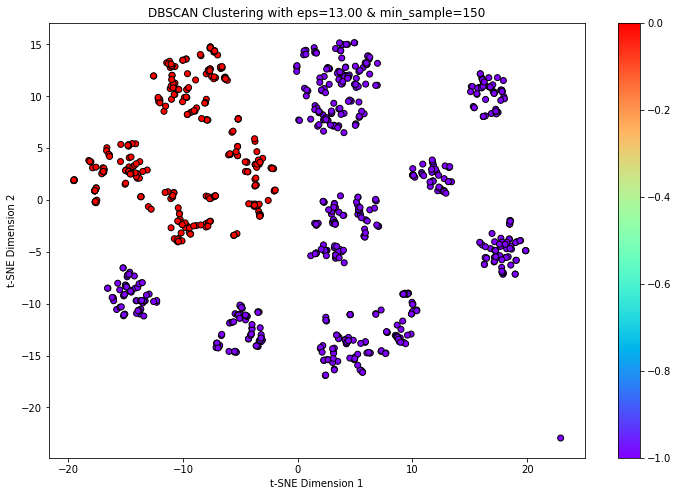

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


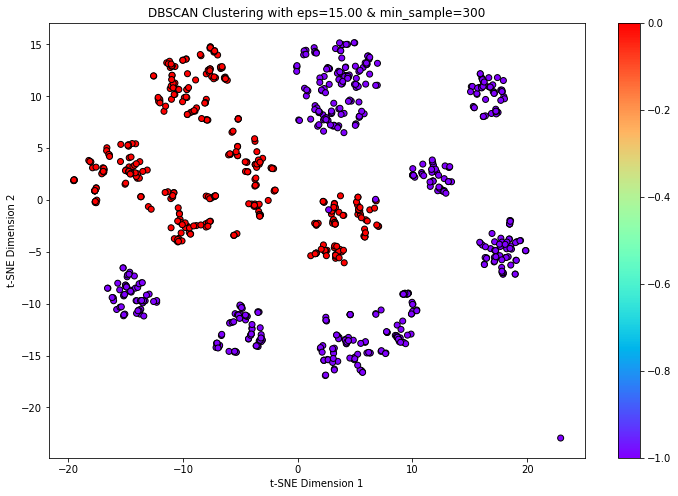

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


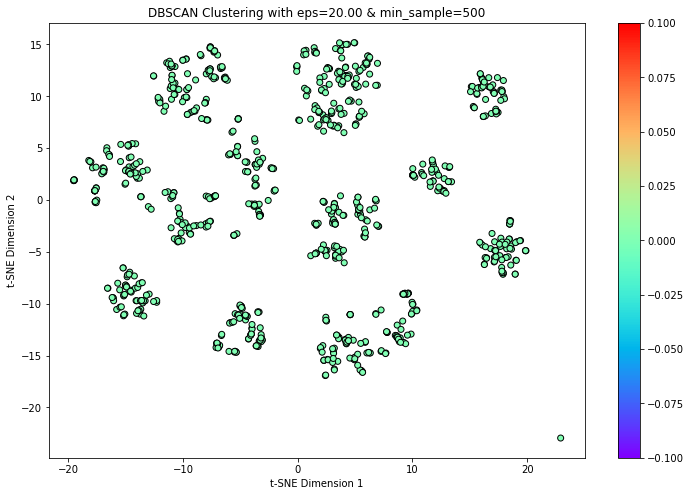

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


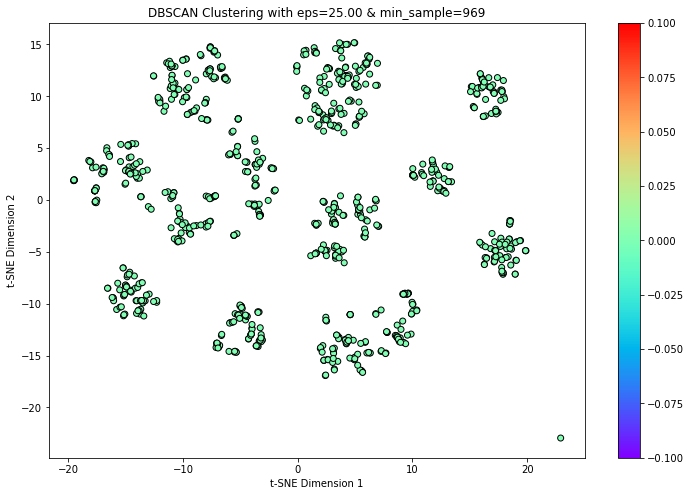

In [93]:
from sklearn.cluster import DBSCAN
# eps is observed from the previous graphs
eps = [2,6,13,13,15,20,25]
for i in range(len(minS)):
    dbscan = DBSCAN(eps=eps[i], min_samples=minS[i])#I did not specify distance metric, so it defaults to the Euclidean distance
    dbscan_clusters = dbscan.fit_predict(df1)

    # Reduce dimensionality for visualization using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=527)
    reduced_data = tsne.fit_transform(df1)

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                c=dbscan_clusters, cmap='rainbow', edgecolor='k')
    plt.title('DBSCAN Clustering with eps=%.2f & min_sample=%d' % (eps[i], minS[i]))
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar()
    plt.show()

#### Given the immense size of the dataset, using the hierarchical clustering method discussed in class is suboptimal. This is because the resulting dendrogram can become overly complex and difficult to interpret. Additionally, the time complexity for computation would be substantial.
#### I opted for DBSCAN as an alternative clustering method. One of its strengths is its density-based approach. With our binary data, certain combinations of binary features might frequently appear together. 
#### A small eps paired with a small min_samples tends to produce many noise points (points that do not belong to any clusters), and results in fewer clusters containing only a small amount of data. The method is most optimal when eps is set to 12 and min_samples is 100, which I observed that there are two clusters with a reasonable number of data points, while the remaining data points are considered noise. As both eps and min_samples increase, the number of clusters and noise points decrease. When min_samples equals the total number of rows in our dataset, all the points coalesce into a single cluster with no noise points. This is expected because when we consider every point in our dataset as the minimum requirement for density, the entire dataset naturally forms a single cluster, regardless of the eps value.



## Cluster with different distance metric: Cosine Distance

/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/77wu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


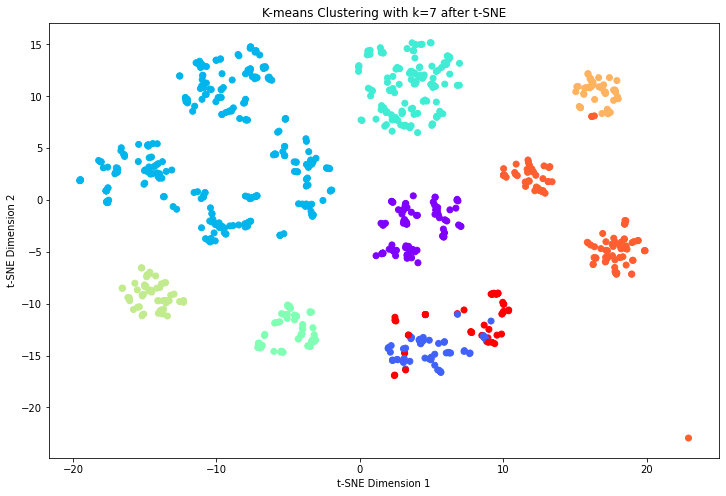

In [89]:
from sklearn.metrics import pairwise_distances

# Compute the cosine distance matrix
distance_matrix = pairwise_distances(df1, metric="cosine")

#Perfrom k-mean with 9 cluster and set a seed 527 as the initial centroids
kmeans = KMeans(n_clusters=9, random_state=527)
#By default, it uses Euclidean distance
clusters = kmeans.fit_predict(distance_matrix)
#Visualize using tSNE
reduced = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=527).fit_transform(df1)

#Plotting the clusters
plt.figure(figsize=(12, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='rainbow')
plt.title('K-means Clustering with k=7 after t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

#### I chose the Cosine Distance as the alternative distance metric, given that our data is composed entirely of binary values. One of the main advantages of using the Cosine Distance is its insensitivity to the magnitude of vectors, making it particularly apt for our dataset.


## Write-Ups: Commonalities / Differences

### KMean vs. DBSCAN

#### 1)  Both the t-SNE plots for KMeans and DBSCAN show clusters that tend to be spherical. This observation is consistent with the nature of their distance metrics, as both methods use the Euclidean distance metric. The formula for Euclidean distance is reminiscent of the equation used to determine the radius of a circle or sphere.
#### 2) Since we identified 9 as the optimal number of clusters for KMeans, the plot displays nine distinct colors. In contrast, DBSCAN doesn't require us to specify the number of clusters beforehand. Through experimentation with different values, we found that setting min_sample to around 100 yields the best balance between the number of clusters and noise points. Interestingly, if we divide the total number of rows (969) by 9 (the average number of data points in a cluster), we get approximately 100. This coincides with the optimal min_sample value for our DBSCAN method.

#### 3) Comparing the t-SNE visualizations for KMeans and DBSCAN, the distribution of points remains consistent, with only the coloring (indicating cluster assignments) differing. DBSCAN introduces a new set of points that does not belong to any clusters, and the kmean method is not good at detecting those noise and will try to group them together. 



### Euclidean vs. Cosine

#### Both KMeans and DBSCAN utilize the Euclidean distance metric by default. This metric emphasizes the magnitude of vectors, making it suitable for a wide range of applications. However, when dealing with datasets composed solely of binary values, the magnitude of vectors may not be as informative. In such scenarios, I conclude that the Euclidean distance might not be the most appropriate metric in our case.

#### I decided to try the Cosine distance metric as it seems to be more appropriate for binary number. The reason is that cosine distance captures the similarity in orientation and structure rather than sheer magnitude.

#### When comparing the KMeans cluster graphs (one utilizing the Euclidean distance metric and the other the Cosine distance metric) I observed distinct clustering behaviors. Data points that were grouped into a single cluster using the Euclidean metric were separated into two clusters when employing the Cosine metric. Conversely, points that spanned two clusters under the Euclidean metric were merged into a singular cluster with the Cosine metric. 
#### This discrepancy can be attributed to how these metric measure distance and similarity. Especially, Cosine metric cares orientation matters more than absolute distances, so Cosine metric can lead to substantially different clustering results.

